## Predict Future Sales (Time Series)

Kaggle Competition

**Goal**: Predict total sales for every product and store for November 2015. <br>
**Data Given**: Daily historical data from January 2013 to October 2015. <br>

#### 1. Import packages and data

In [2]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats

# Visualistion
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# settings
import warnings
warnings.filterwarnings("ignore")

In [124]:
# Import all of them 
sales=pd.read_csv("sales_train.csv")
# sales=pd.read_csv("sales_train.csv",index_col='date',parse_dates=True)
# item_cat=pd.read_csv("item_categories-translated.csv")
# item=pd.read_csv("items-translated.csv")
# sub=pd.read_csv("sample_submission.csv")
# shops=pd.read_csv("shops-translated.csv")
test=pd.read_csv("test.csv")

Thanks to deargle who translated the Russian to English. <br>
https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/discussion/54949

#### 2. Compress data size

In [125]:
def downcast_dtypes(df, verbose = True):
    start_mem = df.memory_usage().sum() / 1024**2
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

sales = downcast_dtypes(sales, verbose = True)
print(sales.info())

Mem. usage decreased to 61.60 Mb (54.2% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int16  
 2   shop_id         int16  
 3   item_id         int16  
 4   item_price      float32
 5   item_cnt_day    float32
dtypes: float32(2), int16(3), object(1)
memory usage: 61.6+ MB
None


The data is now much lighter!!

#### 3. Data Structure

In [15]:
# Check Null values
sales.isnull().sum()

date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

Great, there is no missing values.

In [14]:
# Check how many rows & columns
sales.shape

(2935849, 5)

Almost 3 miliion rows of data.

In [63]:
sales['revenue'] = sales.item_price.values * sales.item_cnt_day.values

In [64]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00


In [43]:
# Number of returns
len(sales[sales.item_cnt_day < 0])

7356

In [46]:
sales['month'] = sales.date.dt.month
sales['year'] = sales.date.dt.year
sales['day_of_week'] = sales.date.dt.day_of_week

In [47]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,reveunue,month,year,day_of_week
0,2013-01-02,0,59,22154,999.000000,1.0,999.000000,1,2013,2
1,2013-01-03,0,25,2552,899.000000,1.0,899.000000,1,2013,3
2,2013-01-05,0,25,2552,899.000000,-1.0,-899.000000,1,2013,5
3,2013-01-06,0,25,2554,1709.050049,1.0,1709.050049,1,2013,6
4,2013-01-15,0,25,2555,1099.000000,1.0,1099.000000,1,2013,1


In [6]:
sales['Month'] = sales['date'].dt.to_period('M')

In [7]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,Month
0,2013-01-02,0,59,22154,999.000000,1.0,2013-01
1,2013-01-03,0,25,2552,899.000000,1.0,2013-01
2,2013-01-05,0,25,2552,899.000000,-1.0,2013-01
3,2013-01-06,0,25,2554,1709.050049,1.0,2013-01
4,2013-01-15,0,25,2555,1099.000000,1.0,2013-01


<AxesSubplot:xlabel='Month'>

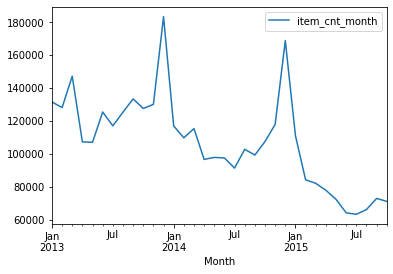

In [8]:
salesPerMonth = sales.groupby(['Month']).agg({'item_cnt_day' : 'sum'})
salesPerMonth.reset_index(inplace=True)
salesPerMonth = salesPerMonth.set_index('Month')
salesPerMonth.rename(columns = {'item_cnt_day':'item_cnt_month'}, inplace = True)
salesPerMonth.plot()

#### 4. Feature Engineering

In [126]:
sales.date = pd.to_datetime(sales.date, format = '%d.%m.%Y')

In [127]:
sales['Month'] = sales['date'].dt.to_period('M')

In [128]:
sales_df = sales.groupby(['Month']).agg({'item_cnt_day':'sum'})

In [129]:
sales_df.rename(columns = {'item_cnt_day':'mthly_sold'}, inplace = True)

In [130]:
sales_df.head()

,mthly_sold
Month,
2013-01,131479.0
2013-02,128090.0
2013-03,147142.0
2013-04,107190.0
2013-05,106970.0


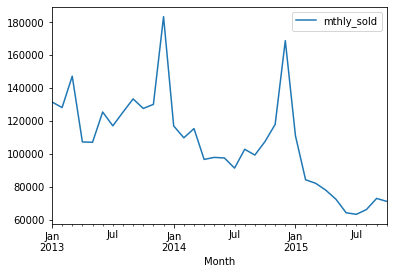

In [131]:
# Plot time series
sales_df.plot()
plt.show()

#### 5. Box-Jenkins Time Series

##### 5.1 Identification

###### 5.1.1 Check stationarity

In [132]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("ADF : ",dftest[0])
     print("P-Value : ", dftest[1])
     print("Num Of Lags : ", dftest[2])
     print("Num Of Observations Used For ADF Regression:", dftest[3])
     print("Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)

test_stationarity(sales_df['mthly_sold'])

ADF :  -2.3957040669944325
P-Value :  0.1429525769929046
Num Of Lags :  0
Num Of Observations Used For ADF Regression: 33
Critical Values :
	 1% :  -3.6461350877925254
	 5% :  -2.954126991123355
	 10% :  -2.6159676124885216


p-value is not < 0.5, hence, this is not stationary

###### 5.1.2 make dataset stationary

In [133]:
# multiplicative: First apply log transform
sales_df= np.log(sales_df)

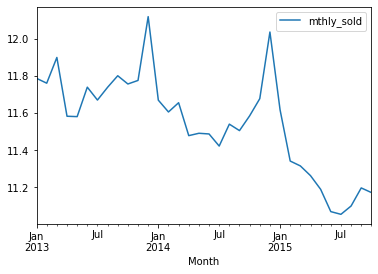

In [134]:
sales_df.plot()
plt.show()

In [135]:
sales_df_stationary = sales_df.diff()
sales_df_stationary = sales_df.diff().dropna()

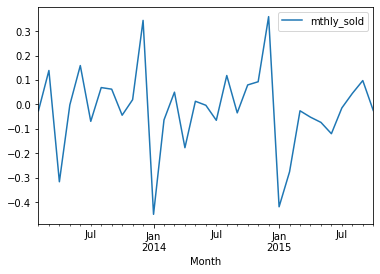

ADF Statistic: -6.974166116899589
p-value: 8.51304339888802e-10


In [136]:
# Run ADF test on the differenced time series
result = adfuller(sales_df_stationary['mthly_sold'])

# Plot the differenced time series
fig, ax = plt.subplots()
sales_df_stationary.plot(ax=ax)
plt.show()

# Print the test statistic and the p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

p-value is now less than 0.5, this means we achieved stationary

###### 5.1.3 ACF & PACF

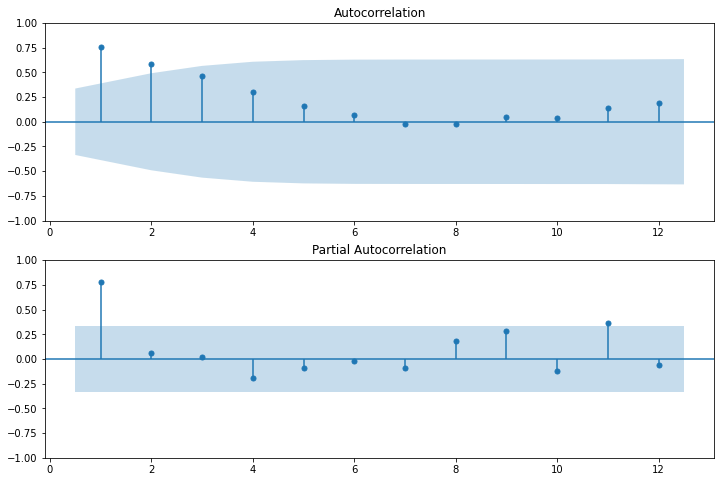

In [137]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of savings on ax1
plot_acf(sales_df, lags=12, zero=False, ax=ax1)

# Plot the PACF of savings on ax2
plot_pacf(sales_df, lags=12, zero=False, ax=ax2)

plt.show()

This looks like an AR(1) model

##### 5.2 Estimation

###### 5.1.1 AIC or BIC

In [138]:
order_aic_bic=[]
# Loop over p values from 0-2
for p in range(3):
    # Loop over q values from 0-2
    for q in range(3):
      
        try:
            # create and fit ARMA(p,q) model
            model = SARIMAX(sales_df, order=(p,0,q))
            results = model.fit()
            
            # Append order and results tuple
            order_aic_bic.append((p,q,results.aic,results.bic))
            
        except:
            order_aic_bic.append((p,q,None, None))            

# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

   p  q         AIC         BIC
3  1  0  -10.989741   -7.937020
4  1  1  -10.640632   -6.061550
6  2  0  -10.114122   -5.535040
5  1  2   -9.358698   -3.253255
8  2  2   -6.972533    0.659269
7  2  1   -6.923687   -0.818245
2  0  2  186.707719  191.286801
1  0  1  224.307139  227.359860
0  0  0  264.874686  266.401046
   p  q         AIC         BIC
3  1  0  -10.989741   -7.937020
4  1  1  -10.640632   -6.061550
6  2  0  -10.114122   -5.535040
5  1  2   -9.358698   -3.253255
7  2  1   -6.923687   -0.818245
8  2  2   -6.972533    0.659269
2  0  2  186.707719  191.286801
1  0  1  224.307139  227.359860
0  0  0  264.874686  266.401046


Both AIC and BIC suggested AR(1)

##### 5.3 Model Diagnostics

In [139]:
# Take the first and seasonal differences and drop NaNs
sales_df_diff = sales_df.diff().dropna()

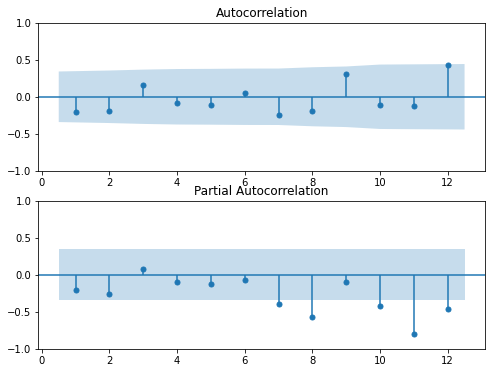

In [140]:
# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

# Plot the ACF on ax1
plot_acf(sales_df_diff, lags=12, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(sales_df_diff, lags=12, zero=False, ax=ax2)

plt.show()

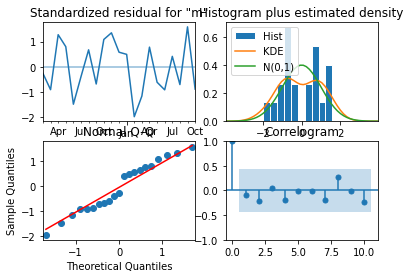

                                     SARIMAX Results                                      
Dep. Variable:                         mthly_sold   No. Observations:                   34
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  19.773
Date:                            Sat, 13 Aug 2022   AIC                            -31.545
Time:                                    16:41:32   BIC                            -27.367
Sample:                                01-31-2013   HQIC                           -30.639
                                     - 10-31-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0092      0.018     -0.508      0.611      -0.045       0.026
ar.L1         -0.3456      0.270   

In [141]:
# Create and fit model
model = SARIMAX(sales_df, order=(1,1,0),seasonal_order=(1,1,0,12), trend='c')
results=model.fit()

# Create the 4 diagostics plots
results.plot_diagnostics()
plt.show()

# Print summary
print(results.summary())

Prob(Q) & Prob(JB) are both more than 0.5, this means residuals are uncorrelated and normally distributed

##### 5.4 Production

In [142]:
# Generate predictions
one_step_forecast = results.get_prediction(start=-30)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
# lower_limits = confidence_intervals.loc[:,'lower close']
# upper_limits = confidence_intervals.loc[:,'upper close']

# Print best estimate  predictions
print(mean_forecast)

Month
2013-05    11.571933
2013-06    11.569879
2013-07    11.728688
2013-08    11.659214
2013-09    11.727970
2013-10    11.790172
2013-11    11.745768
2013-12    11.764934
2014-01    17.996772
2014-02    11.632527
2014-03    11.743005
2014-04    11.355126
2014-05    11.413620
2014-06    11.630258
2014-07    11.459542
2014-08    11.474922
2014-09    11.570940
2014-10    11.479946
2014-11    11.547170
2014-12    11.980531
2015-01    11.569785
2015-02    11.521833
2015-03    11.420078
2015-04    11.191675
2015-05    11.244132
2015-06    11.151448
2015-07    11.016433
2015-08    11.162665
2015-09    11.052499
2015-10    11.251723
Freq: M, Name: predicted_mean, dtype: float64


In [153]:
forecast = results.get_forecast(steps=2)

# forecast mean
mean_forecast = forecast.predicted_mean

# Get confidence intervals of forecasts
confidence_intervals = forecast.conf_int()

np.exp(mean_forecast)

2015-11     83332.329635
2015-12    117166.768588
Freq: M, Name: predicted_mean, dtype: float64

In [ ]:
# plot the amazon data
plt.plot(sales_df.index, sales_df.values, label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
# plt.fill_between(lower_limits.index, lower_limits, 
#                upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

#### 6. Model Fitting

##### 6.1 Train test split

##### 6.2 ARIMA

##### 6.3 Auto ARIMA + SHIFT

#### 7. Prediction and validation

#### 8. Submission